In [2]:
import pyfolio as pf
import matplotlib.pyplot as plt
import pandas as pd
import backtrader as bt
import datetime
import quantstats
import backtrader.indicators as btind

Starting Portfolio Value: 100000.00
Final Portfolio Value: -14399561.15


c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)
c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


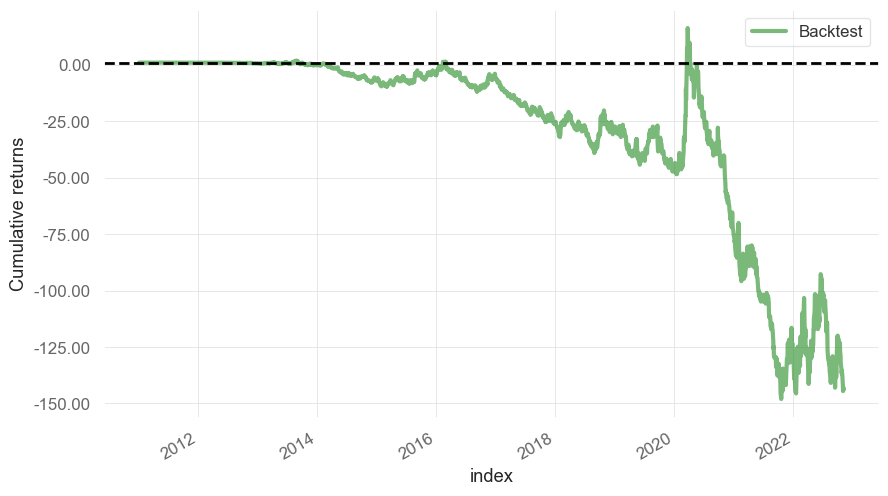

In [3]:
# Create a Stratey
class DirectionalStrategy(bt.Strategy):
    params = (
        ('fast_period', 10),
        ('slow_period', 30),
        ('takeprofit_percent', 0.05),
        ('stoploss_percent', 0.05),
    )

    def __init__(self):
        self.fast_sma = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.fast_period)
        self.slow_sma = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.slow_period)

        self.takeprofit_level = 0
        self.stoploss_level = 0
        self.stop_price = 0

    def next(self):
        if self.data.datetime.datetime().month in [1, 3, 9]:
            return
        if not self.position:  # If no position is open
            if self.fast_sma > self.slow_sma:  # Buy signal
                takeprofit_price = self.data.close[0] * (1 + self.params.takeprofit_percent)
                stoploss_price = self.data.close[0] * (1 - self.params.stoploss_percent)
                self.stop_price = stoploss_price
                self.takeprofit_level = takeprofit_price
                self.stoploss_level = stoploss_price
                self.buy(price=self.data.close[0], exectype=bt.Order.Stop, parent=None, stopprice=stoploss_price)
        else:
            if self.data.close[0] >= self.takeprofit_level:  # Take profit
                self.sell(price=self.data.close[0], exectype=bt.Order.Limit, parent=None, limitprice=self.takeprofit_level)
            elif self.data.close[0] <= self.stoploss_level:  # Stop loss
                self.sell(price=self.data.close[0], exectype=bt.Order.Market, parent=None)

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(DirectionalStrategy)
    
    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname='../nifty_daily_continous.csv',
        # Do not pass values before this date
        fromdate=datetime.datetime(2011, 1, 3),
        # Do not pass values before this date
        todate=datetime.datetime(2022, 11, 7),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Create an instance of an Analyzer subclass and add it to the Cerebro object
    cerebro.addanalyzer(bt.analyzers.SharpeRatio)

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
    results = cerebro.run()
    strat = results[0]
    portfolio_stats = strat.analyzers.getbyname('PyFolio')
    returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
    returns.index = returns.index.tz_convert(None)

    quantstats.reports.html(returns, output='stats.html', title='Nifty Sentiment')
    '''data = cerebro.plot()
    data[0][0].savefig("directional.png")'''

    pf.plotting.plot_rolling_returns(returns)

## Monte Carlo Simulation

In [4]:
returns = pd.DataFrame({'datetime': returns.index, 'pnl': returns.values})

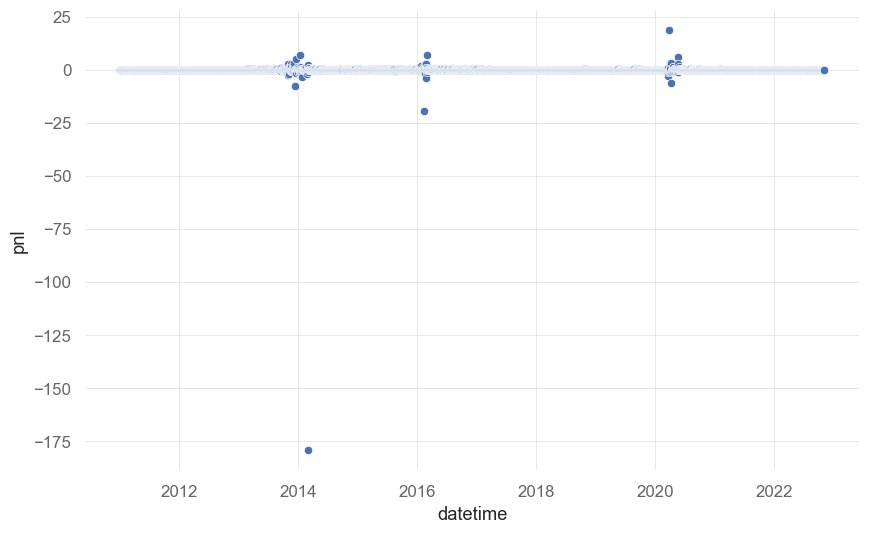

In [5]:
import seaborn as sns
sns.scatterplot(x=returns['datetime'], y=returns['pnl'])

In [6]:
def calc_max_dd(data_series):
    '''
    Inputs:
    data_series (pd.Series): A series of percentage returns of the strategy
    Returns:
    Maximum Drawdown (float)
    '''
    cumm_ret = data_series.cumsum()

    hwm = cumm_ret.cummax()
    dd = cumm_ret-hwm
    return round(dd.min(), 2)


In [7]:
def monte_carlo(simulations, df):
      mdd_list = []
      for s in range(simulations):
        mdd=0
        reshuffle=df['pnl'].sample(frac=1).reset_index(drop=True)
        plt.plot(reshuffle.cumsum())
        mdd=calc_max_dd(reshuffle)
        mdd_list.append(mdd)
      plt.plot(df['pnl'].cumsum(),linewidth=3,color='black')
      plt.xlabel('Trade No.')
      plt.ylabel('Cummulative Returns')
      plt.title('Monte Carlo Simulation for {} Simulations'.format(simulations))
      plt.show()
      return mdd_list

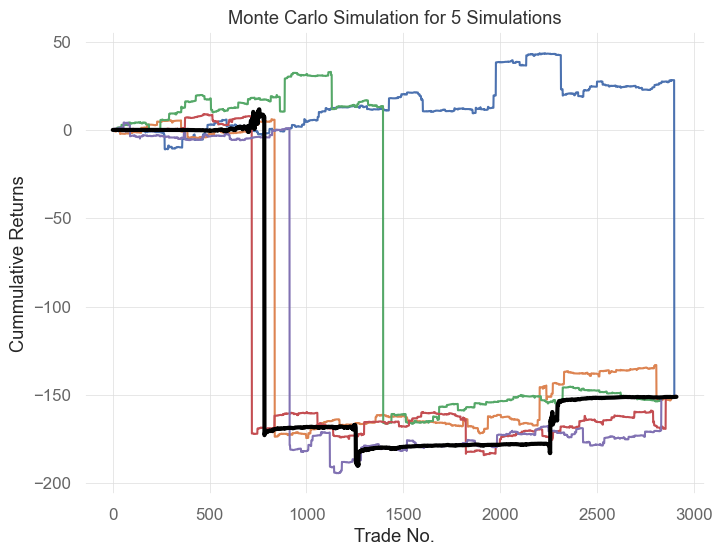

In [8]:
simulations = 5
plt.figure(figsize=(8, 6))
mdd_list = monte_carlo(simulations, returns)

In [9]:
mdd_list

[-194.77, -180.56, -199.29, -193.11, -198.59]

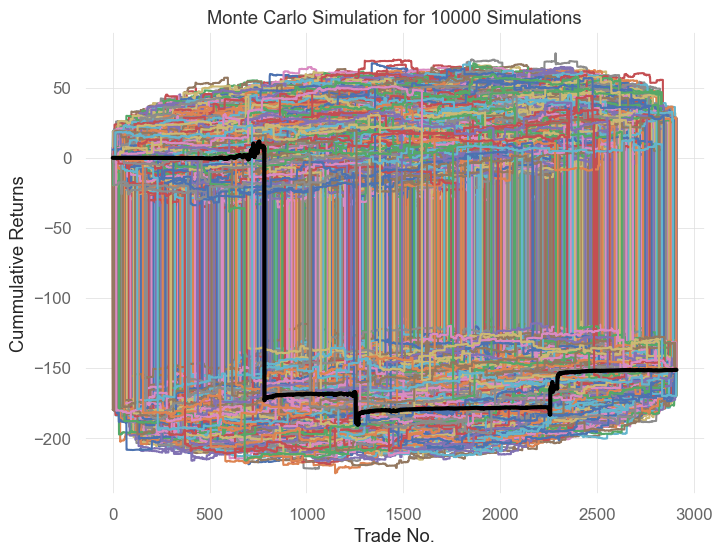

In [10]:
simulations = 10000
plt.figure(figsize=(8, 6))
mdd_list = monte_carlo(simulations, returns)

In [11]:
df_mdd = pd.DataFrame(mdd_list, columns=['Max DD'])

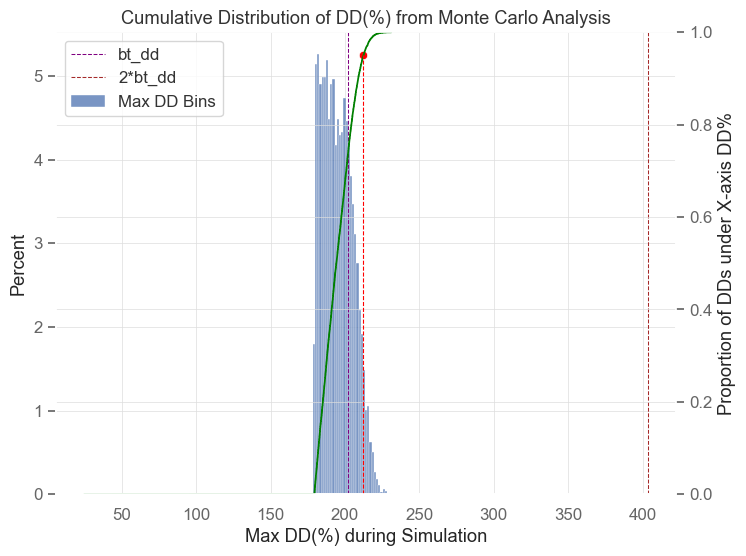

Backtest Drawdown: -201.79% , The 95.0 percentile of the Drawdown based on Monte Carlo is:212.41%


In [12]:
import numpy as np
n_tile = 0.95  # Cut-Off Percentile to plot
n_tile_value = np.round(df_mdd['Max DD'].quantile(q=1-n_tile), 2)
bt_dd = calc_max_dd(returns['pnl'])
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(ax=ax, x=-1*df_mdd['Max DD'], stat='percent')  # ,cumulative=True)
ax.set_title('Cumulative Distribution of DD(%) from Monte Carlo Analysis')
ax.set_xlabel('Max DD(%) during Simulation')
ax.axvline(-bt_dd, ymax=1, color='purple', linestyle='dashed', linewidth=0.75)
ax.axvline(-2*bt_dd, ymax=1, color='brown', linestyle='dashed', linewidth=0.75)
ax.legend(labels=['bt_dd', '2*bt_dd', 'Max DD Bins'])
ax2 = ax.twinx()
sns.ecdfplot(ax=ax2, x=-1*df_mdd['Max DD'], color='green', linewidth=1.25)
sns.scatterplot(x=[-1*n_tile_value], y=[n_tile], ax=ax2, color='red')
ax2.axvline(-1*n_tile_value, ymax=n_tile, color='red',
            linestyle='dashed', linewidth=0.8)
ax2.set_ylabel('Proportion of DDs under X-axis DD%')
plt.show()
print(
    f'Backtest Drawdown: {bt_dd}% , The {n_tile*100} percentile of the Drawdown based on Monte Carlo is:{-1*n_tile_value}%')